/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_72764/1795280934.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['passer'] = pas
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_72764/1795280934.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['recipient'] = rec
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not fo

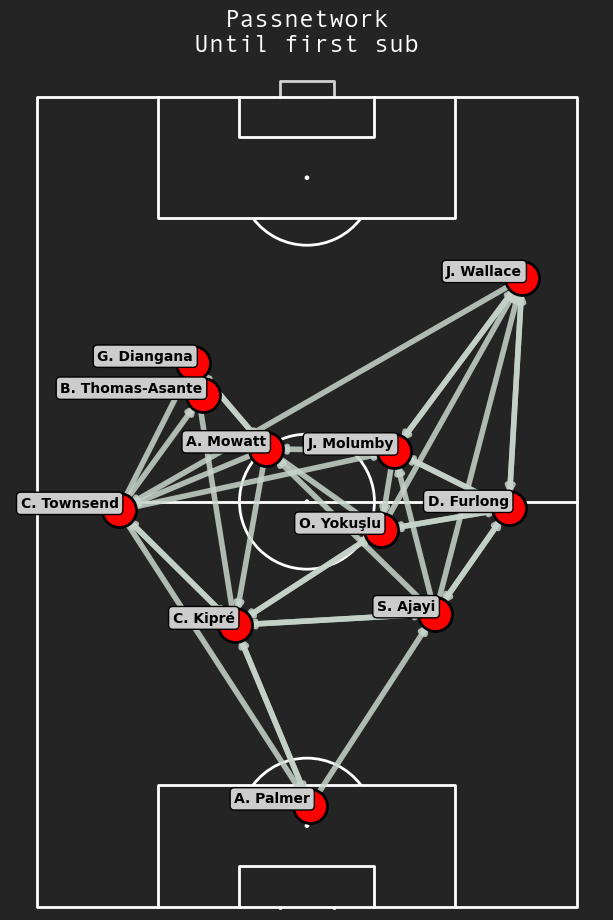

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_72764/1795280934.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['passer'] = pas
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_72764/1795280934.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['recipient'] = rec
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not 

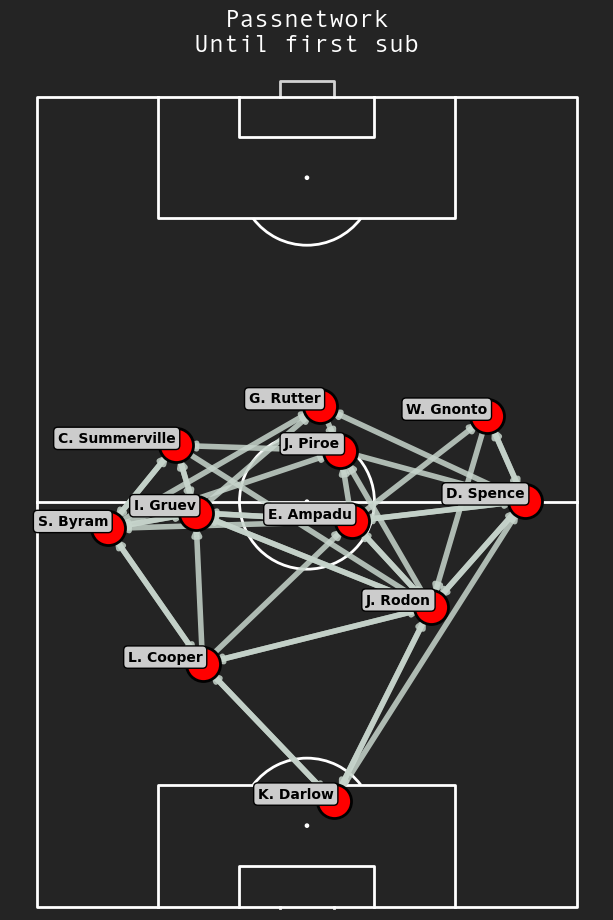

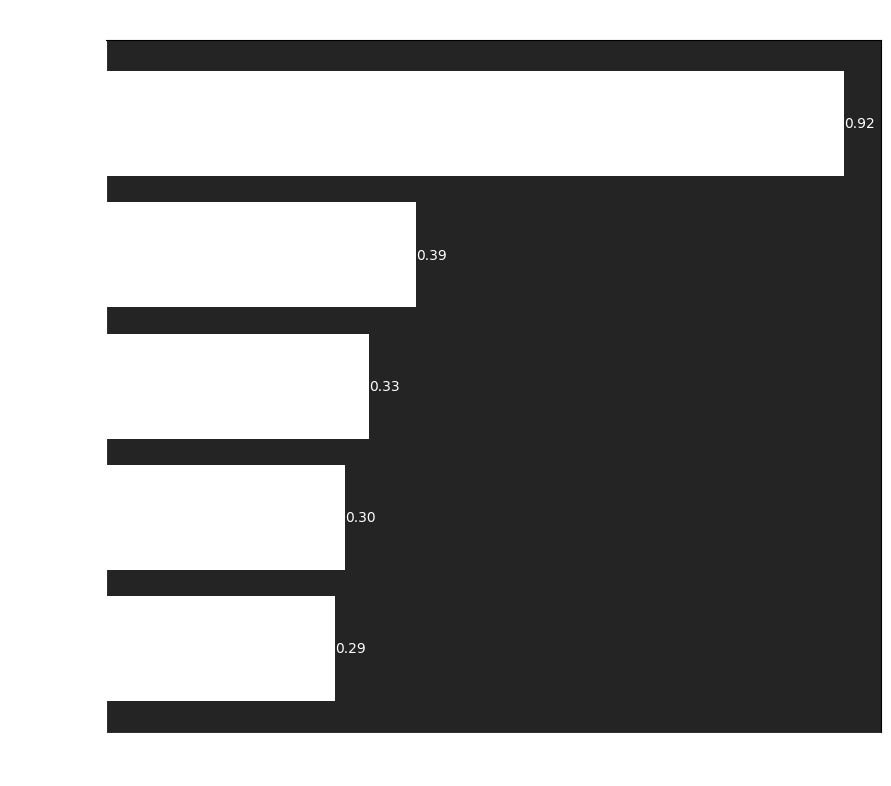

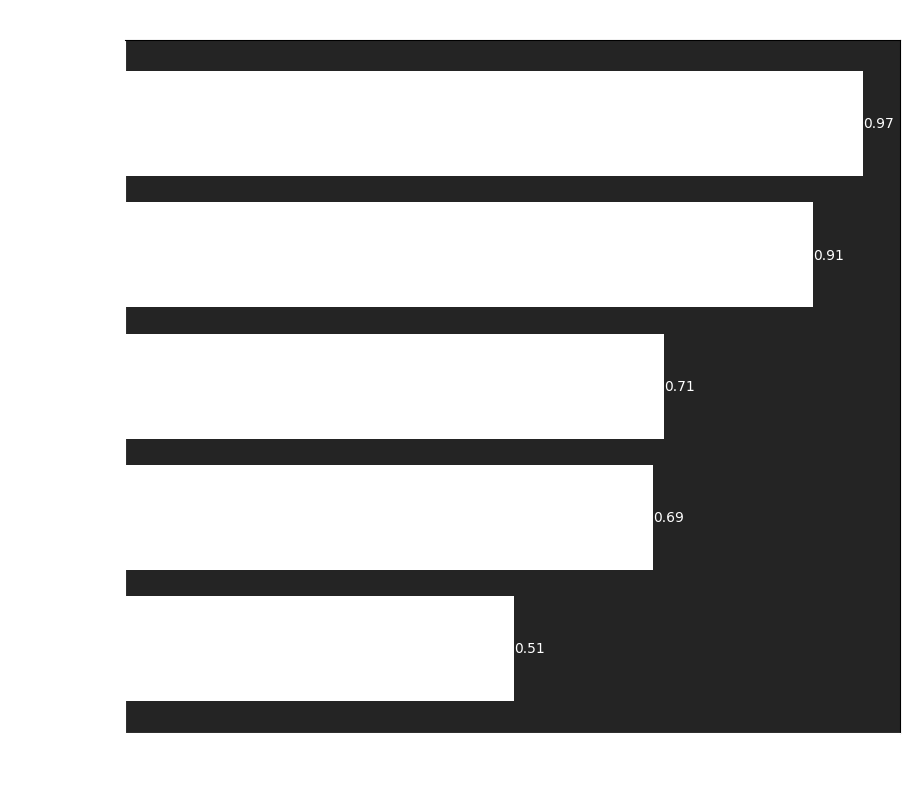

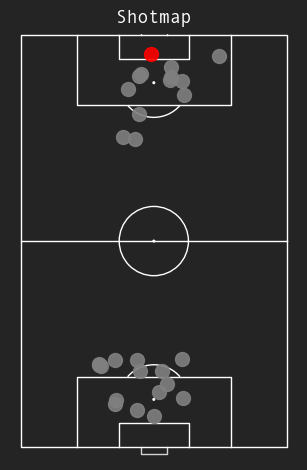

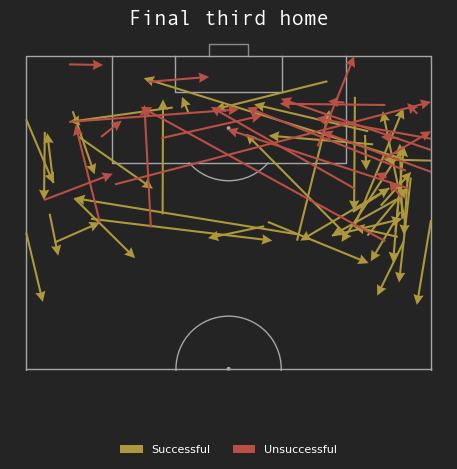

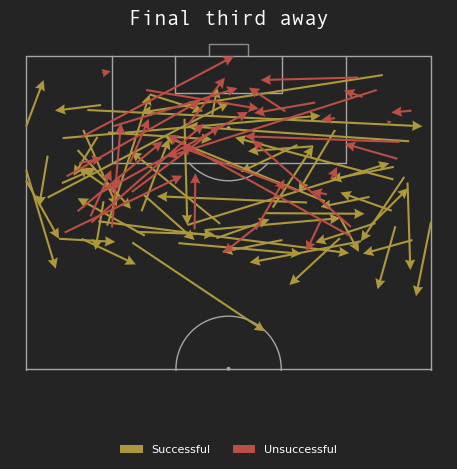

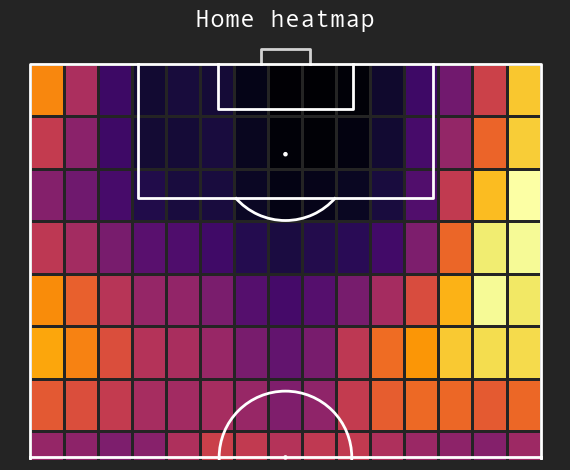

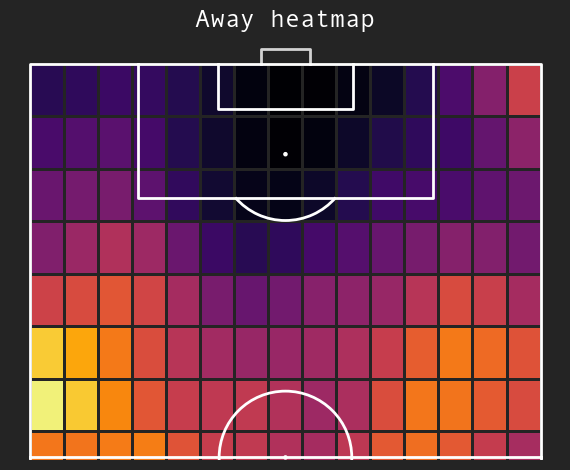

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib.colors as mpl_colors
import math
import mplsoccer

df = pd.read_excel("Pass.xlsx")

HomeTeam = 'd1lhefp805y0rcbjqkpu4fq0n'
AwayTeam = '48gk2hpqtsl6p9sx9kjhaydq4'

OneTeam = df.loc[df['contestantId'] == HomeTeam].reset_index()

OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]

OneTeam.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# find time of the team's first substitution and filter the df to only passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

pas = Completions['passer']
rec = Completions['recipient']

Completions['passer'] = pas
Completions['recipient'] = rec

Completions = Completions.loc[Completions['newsecond'] < SubOne]

average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occurred at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(16, 11))

pitch = mplsoccer.VerticalPitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                                line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")


def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(80 - 0.8 * end_y, 1.2 * end_x), xytext=(80 - 0.8 * y, 1.2 * x), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))


def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)


for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# plot nodes
pass_box = pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
                         color='#FF0000', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# annotation/key at bottom
pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occurred Over 2 Times",
               (-4, 40), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold',
               fontfamily="Andale Mono")

# Uncomment these next two lines to get each node labeled with the player id.
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2 * row.x, 80 - 0.8 * row.y), bbox=dict(boxstyle="round", fc="0.8"), c='black',
                    va='bottom', ha='right', size=10, fontweight='bold', fontfamily="Century Gothic", ax=ax)

# Set the background color
fig.patch.set_facecolor('#242424')

# annotations
ax.set_title("Passnetwork\nUntil first sub", fontsize=18, color="w", fontfamily="Andale Mono",
             fontweight='bold', pad=8)

plt.savefig('Passnetwork Home.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()

df = pd.read_excel("Pass.xlsx")

OneTeam = df.loc[df['contestantId'] == AwayTeam].reset_index()

OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]

OneTeam.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# find time of the team's first substitution and filter the df to only passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

pas = Completions['passer']
rec = Completions['recipient']

Completions['passer'] = pas
Completions['recipient'] = rec

Completions = Completions.loc[Completions['newsecond'] < SubOne]

average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occurred at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(16, 11))

pitch = mplsoccer.VerticalPitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                                line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")


def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(80 - 0.8 * end_y, 1.2 * end_x), xytext=(80 - 0.8 * y, 1.2 * x), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))


def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)


for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# plot nodes
pass_box = pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
                         color='#FF0000', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# annotation/key at bottom
pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occurred Over 2 Times",
               (-4, 40), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold',
               fontfamily="Andale Mono")

# Uncomment these next two lines to get each node labeled with the player id.
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2 * row.x, 80 - 0.8 * row.y), bbox=dict(boxstyle="round", fc="0.8"), c='black',
                    va='bottom', ha='right', size=10, fontweight='bold', fontfamily="Century Gothic", ax=ax)

# Set the background color
fig.patch.set_facecolor('#242424')

# annotations
ax.set_title("Passnetwork\nUntil first sub", fontsize=18, color="w", fontfamily="Andale Mono",
             fontweight='bold', pad=8)

plt.savefig('Passnetwork Away.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()

#XT home

df = pd.read_excel('xT.xlsx')
df = df.loc[df['contestantId'] == HomeTeam].reset_index()
df_grouped = df.groupby('playerName')['xT'].sum().reset_index()
df_top10 = df_grouped.sort_values('xT', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10, 9))  # Set the figure size here
plt.barh(df_top10['playerName'], df_top10['xT'], align='center', color='white')
plt.xlabel('xT')
plt.title("Top xT performers - Home", fontsize=20, color="w")
ax.patch.set_facecolor('#242424')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.invert_yaxis() # Add this line to invert the y-axis


for i, v in enumerate(df_top10['xT']):
    ax.text(v + 0.0001, i, f"{v:.2f}", color='white', va='center', ha='left')
    
plt.savefig('xT home.png', dpi=750, bbox_inches = 'tight', facecolor='#242424')

#XT away

df = pd.read_excel('xT.xlsx')
df = df.loc[df['contestantId'] == AwayTeam].reset_index()
df_grouped = df.groupby('playerName')['xT'].sum().reset_index()
df_top10 = df_grouped.sort_values('xT', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10, 9))  # Set the figure size here
plt.barh(df_top10['playerName'], df_top10['xT'], align='center', color='white')
plt.xlabel('xT')
plt.title("Top xT performers - Away", fontsize=20, color="w")
ax.patch.set_facecolor('#242424')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.invert_yaxis() # Add this line to invert the y-axis


for i, v in enumerate(df_top10['xT']):
    ax.text(v + 0.0001, i, f"{v:.2f}", color='white', va='center', ha='left')
    
plt.savefig('xT away.png', dpi=750, bbox_inches = 'tight', facecolor='#242424')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from matplotlib import patches

text_color = 'w'
df = pd.read_excel('Pass.xlsx')
team1 = df.loc[df['contestantId'] == HomeTeam].reset_index()
team2 = df.loc[df['contestantId'] == AwayTeam].reset_index()


pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='white', linewidth=1,
                      half=False,
                      goal_type='box',
                      goal_alpha=0.8)

fig, ax = pitch.draw()
fig.set_facecolor('#242424')


for x in range(len(team1['x'])):
    if team1['typeId'][x] == 16:
        plt.scatter(team1['y'][x], 100 - team1['x'][x], color='red', s=100, alpha=.9, zorder=3)
    if team1['typeId'][x] == 13:
        plt.scatter(team1['y'][x], 100 - team1['x'][x], color='grey', s=100, alpha=.9, zorder=2)   
    if team1['typeId'][x] == 14:
        plt.scatter(team1['y'][x], 100 - team1['x'][x], color='grey', s=100, alpha=.9, zorder=2)
    if team1['typeId'][x] == 15:
        plt.scatter(team1['y'][x], 100 - team1['x'][x], color='grey', s=100, alpha=.9, zorder=2)

# team2 will feature right        
for x in range(len(team2['x'])):
    if team2['typeId'][x] == 16:
        plt.scatter(team2['y'][x], team2['x'][x], color='red', s=100, alpha=.9, zorder=3)
    if team2['typeId'][x] == 13:
        plt.scatter(team2['y'][x], team2['x'][x], color='grey', s=100, alpha=.9, zorder=2)
    if team2['typeId'][x] == 14:
        plt.scatter(team2['y'][x], team2['x'][x], color='grey', s=100, alpha=.9, zorder=2)
    if team2['typeId'][x] == 15:
        plt.scatter(team2['y'][x], team2['x'][x], color='grey', s=100, alpha=.9, zorder=2)  


plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()


 
    

ax.set_title("Shotmap", fontsize=13, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)

#fig.text(.40,0.005,f'@ShePlotsFC / twitter',fontstyle='italic',fontsize=8,fontfamily='Andale Mono', color='w')
plt.savefig('Shotmap.png', dpi=750, bbox_inches = 'tight', facecolor='#242424')


plt.show()

import pandas as pd
import matplotlib.pyplot as plt
from highlight_text import fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch

from matplotlib import patches
import matplotlib.patheffects as path_effects
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from mplsoccer import Pitch, FontManager
import math
from matplotlib.colors import to_rgba
from scipy.spatial import ConvexHull
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


df1 = pd.read_excel("Pass.xlsx")
#df1 = df1.loc[(df1['contestantId']=='cz26xwowfjp8ei14n9z2ac135')].reset_index()
df1 = df1.loc[df1['contestantId'] == HomeTeam].reset_index()



#df1 = df1.loc[df1['progressive']==True].reset_index()

# Change the pitch line color to grey and line width to 1
pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='#a6a6a6',
                      linewidth=1, half=True, goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw()
figsize=(18, 12)
# add Dortmund logo


df1 = df1.loc[df1['x'] > 70]
df1 = df1.loc[df1['endX'] > 50]


for i, x in enumerate(df1['x']):
    if 'outcome' in df1.columns and df1['outcome'].iloc[i] == 1 and df1['Corner'].iloc[i] != 1:#and df1['Cutback'].iloc[i] == 1:
        end_x = pd.Series(df1['endX'].iloc[i]).astype(float)
        end_y = pd.Series(df1['endY'].iloc[i]).astype(float)
        pitch.arrows(df1['x'].iloc[i], df1['y'].iloc[i], end_x, end_y, 
                     width=1.5, zorder=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)

      
        
for i, x in enumerate(df1['x']):
    if 'outcome' in df1.columns and df1['outcome'].iloc[i] == 0 and df1['Corner'].iloc[i] != 1:#and df1['Cutback'].iloc[i] == 1:
        end_x = pd.Series(df1['endX'].iloc[i]).astype(float)
        end_y = pd.Series(df1['endY'].iloc[i]).astype(float)
        pitch.arrows(df1['x'].iloc[i], df1['y'].iloc[i], end_x, end_y, 
                     width=1.5, zorder=2, headwidth=5, headlength=5, color='#ba4f45', ax=ax)
        

   

# Change the background color to grey-black
fig.set_facecolor('#242424')


ax.set_title("Final third home", fontsize=15, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)

# Define colors for legend labels
#colors = {'Successful': '#ad993c', 'Unsuccessful': '#ba4f45'}

# Plot the legend outside the pitch
colors = {'Successful': '#ad993c', 'Unsuccessful': '#ba4f45'}
labels = {'Successful': 'Successful', 'Unsuccessful': 'Unsuccessful'}

# Plot the legend outside the pitch
ax.legend(handles=[patches.Patch(facecolor=color) for color in colors.values()],
          labels=labels.values(), labelcolor='w', loc='lower center', bbox_to_anchor=(0.5, -0.28),
          ncol=2, frameon=False, fontsize=8)
plt.savefig('FT Home.png', dpi=750, bbox_inches='tight', facecolor='#242424')

df1 = pd.read_excel("Pass.xlsx")
#df1 = df1.loc[(df1['contestantId']=='cz26xwowfjp8ei14n9z2ac135')].reset_index()
df1 = df1.loc[df1['contestantId'] == AwayTeam].reset_index()


#df1 = df1.loc[df1['progressive']==True].reset_index()

# Change the pitch line color to grey and line width to 1
pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='#a6a6a6',
                      linewidth=1, half=True, goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw()
figsize=(18, 12)
# add Dortmund logo


df1 = df1.loc[df1['x'] > 70]
df1 = df1.loc[df1['endX'] > 50]


for i, x in enumerate(df1['x']):
    if 'outcome' in df1.columns and df1['outcome'].iloc[i] == 1 and df1['Corner'].iloc[i] != 1:#and df1['Cutback'].iloc[i] == 1:
        end_x = pd.Series(df1['endX'].iloc[i]).astype(float)
        end_y = pd.Series(df1['endY'].iloc[i]).astype(float)
        pitch.arrows(df1['x'].iloc[i], df1['y'].iloc[i], end_x, end_y, 
                     width=1.5, zorder=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)

      
        
for i, x in enumerate(df1['x']):
    if 'outcome' in df1.columns and df1['outcome'].iloc[i] == 0 and df1['Corner'].iloc[i] != 1:#and df1['Cutback'].iloc[i] == 1:
        end_x = pd.Series(df1['endX'].iloc[i]).astype(float)
        end_y = pd.Series(df1['endY'].iloc[i]).astype(float)
        pitch.arrows(df1['x'].iloc[i], df1['y'].iloc[i], end_x, end_y, 
                     width=1.5, zorder=2, headwidth=5, headlength=5, color='#ba4f45', ax=ax)
        
   

#Change the background color to grey-black
fig.set_facecolor('#242424')


ax.set_title("Final third away", fontsize=15, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)

# Define colors for legend labels
#colors = {'Successful': '#ad993c', 'Unsuccessful': '#ba4f45'}

# Plot the legend outside the pitch
colors = {'Successful': '#ad993c', 'Unsuccessful': '#ba4f45'}
labels = {'Successful': 'Successful', 'Unsuccessful': 'Unsuccessful'}

# Plot the legend outside the pitch
ax.legend(handles=[patches.Patch(facecolor=color) for color in colors.values()],
          labels=labels.values(), labelcolor='w', loc='lower center', bbox_to_anchor=(0.5, -0.28),
          ncol=2, frameon=False, fontsize=8)
plt.savefig('FT Away.png', dpi=750, bbox_inches='tight', facecolor='#242424')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from matplotlib import patches


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from matplotlib import patches


df = pd.read_excel("Pass.xlsx")
df = df.loc[df['contestantId'] == HomeTeam].reset_index()#df = df.loc[(df['typeId']==8)].reset_index()
df = df.loc[(df['typeId']==1)].reset_index()
            
pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='white', line_zorder=2,
                      half=True,
                      goal_type='box',
                      goal_alpha=0.8)
            
fig, ax = pitch.draw()
figsize=(18, 12)

pitch.draw

fig.set_facecolor('#242424')
bin_statistic = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(15, 15))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='inferno', edgecolors='#242424')

#fig_text(s="Chelsea vs Brighton 3-1", x=0.25, y=0.8, fontsize=20, color="white", fontfamily='Andale Mono', ax=ax)

ax.set_title("Home heatmap", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)
plt.savefig('Heatmap Home.png', dpi=750, bbox_inches='tight', facecolor='#242424')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from matplotlib import patches


df = pd.read_excel("Pass.xlsx")
df = df.loc[df['contestantId'] == AwayTeam].reset_index()#df = df.loc[(df['typeId']==8)].reset_index()
#df = df.loc[(df['typeId']==8)].reset_index()
df = df.loc[(df['typeId']==1)].reset_index()
            
fig, ax = pitch.draw()
figsize=(18, 12)

pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='white', line_zorder=2,
                      half=True,
                      goal_type='box',
                      goal_alpha=0.8)

pitch.draw

fig.set_facecolor('#242424')
bin_statistic = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(15, 15))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='inferno', edgecolors='#242424')

#fig_text(s="Chelsea vs Brighton 3-1", x=0.25, y=0.8, fontsize=20, color="white", fontfamily='Andale Mono', ax=ax)

ax.set_title("Away heatmap", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=8)
plt.savefig('Heatmap Away.png', dpi=750, bbox_inches='tight', facecolor='#242424')




